# Introduction

This notebook shows all the steps and attempts to model our data, including models that we consider bad or that we later realized there were serious flaws and ended up being discarded at the end.

# Imports and Configuration

In [2]:
%load_ext rpy2.ipython

In [3]:
%reload_ext autoreload
%autoreload 2

import sys
import os
import logging
import warnings
import datetime
import pytz
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx 
import osmnx as ox
import matplotlib.pyplot as plt
import random

from matplotlib import colors, cm
from pathlib import Path 
from shapely.geometry import Point, Polygon, box
from IPython.display import display, Markdown
from scipy.stats import pareto
from scipy.spatial import cKDTree
from mpl_toolkits.axes_grid1 import make_axes_locatable

from datetime import datetime as dt
from datetime import timedelta as td

# Setting matplotlib font size
plt.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', None)

current_path = Path().resolve()
abs_path = str(current_path.parent)
sys.path.append(abs_path)

warnings.filterwarnings("ignore")

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.getLogger('boto3').setLevel(logging.CRITICAL)
logging.getLogger('botocore').setLevel(logging.CRITICAL)


In [4]:
import scripts.pot_holes_cost as phc
from scripts.mod_simplify import simplify_graph
from scripts.h3_explorer import *
from scripts.model_eval import *

In [5]:
from h3 import h3
import folium
import json
from geojson.feature import *

import branca.colormap as bcm
from branca.colormap import linear

from IPython.display import display, HTML, Image
from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster

from pandas.io.json import json_normalize

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [31]:
city = 'Montevideo'
table = 'uy_montevideo_waze_alerts'
start_date = dt(2018,10,2) #rj starts at 12/12
end_date = dt(2019,8,26)
osm_place = {'city' : 'Montevideo',
             'state' : 'Montevideo',
             'country' : 'Uruguay'}
which_result=1

lat_centr_point, lon_centr_point = -34.8305833,-56.236415

RAW_PATH = current_path.parent / 'data' / 'raw' / city
OUTPUT_PATH = current_path.parent / 'data' / 'output' / city

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

# Getting the Data

## Floods

The data related to the floods were extracted from our Big Data server which stores the Waze information. Flood alerts are created by the application's own users to alert others of the road conditions.

In [32]:
flood = pd.read_csv(RAW_PATH/'Athena-flood-Montevideo.csv')

In [33]:
flood = phc.treat_potholes_points(flood)

## Open Street Maps (OSM)

To complement our study, we downloaded the city street information available on Open Street Maps, a collaborative mapping project to create a free, editable map of the world. With a network of more than 2 million collaborators around the world, OSM offers detailed maps of various locations and is an excellent source of information on the road structure of municipalities.

In [34]:
if osm_place:
    G = phc.download_osm_graph(city, osm_place, simplify=False, which_result=which_result)
else:
    lats = flood['latitude'].values
    longs = flood['longitude'].values
    north, south, east, west = max(lats), min(lats), max(longs), min(longs)
    G = phc.download_osm_graph(city, north=north, south=south, east=east, west=west, simplify=False, cached=False, cache_result=False)

In [35]:
G_proj = ox.project_graph(G) 

The image below shows all public roads in the city registered with the OSM.

In [36]:
fig, ax = ox.plot_graph(G_proj, node_size=0, fig_height=10, show=False, axis_off=False, edge_linewidth=0.2)
ax.margins(0)
ax.tick_params(which='both', left=False, bottom=False,  labelleft=False, labelbottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False);

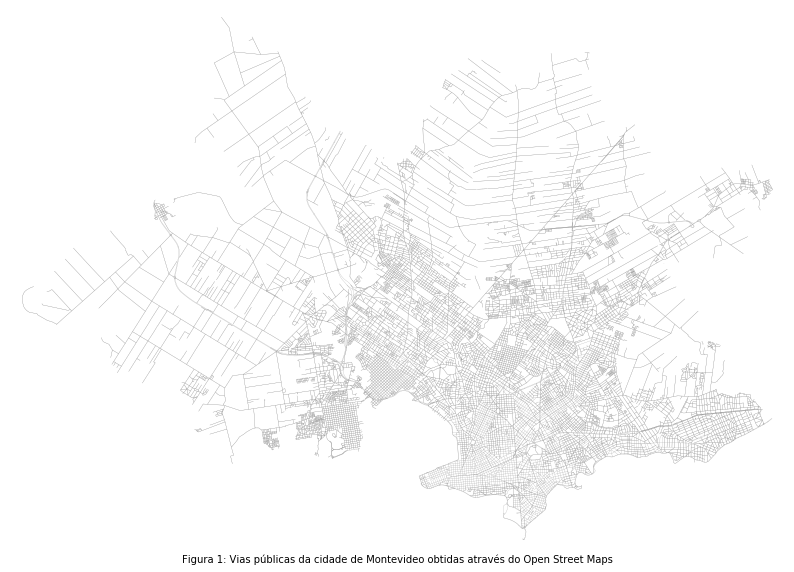

In [37]:
fig

## City's Polygon

In [38]:
pol = ox.gdf_from_place(osm_place, which_result=which_result)

In [39]:
pol.to_csv(OUTPUT_PATH / f'{city}_pol.csv')

## Pluviometry Data

In [40]:
rain_hour = pd.read_csv('../data/montevideo-weather.csv')

In [41]:
rain = pd.read_csv('../data/montevideo-daily_weather.csv')

In [42]:
rain['time'] = rain['time'].apply(dt.fromisoformat).apply(dt.date).apply(pd.to_datetime)
rain = rain.set_index('time')

In [43]:
rain.head(2)

,cloudCover,humidity,precipIntensity,windSpeed
time,,,,
2018-10-01,0.52,0.65,0.2475,6.79
2018-10-02,0.15,0.49,0.0011,2.29


# Usando h3

### Indexando os dados espacialmente com h3

In [44]:
geojson_subzone = pol['geometry'].to_json()

In [45]:
m_hex = choropleth_map(df_aggreg=counts_by_hexagon(df = flood, resolution = 8), zoom_start=11,
                       coords=[lat_centr_point, lon_centr_point], with_legend=True)
            
GeoJson(
        geojson_subzone,
        style_function=lambda feature: {
            'fillColor': None,
            'color': 'blue',
            'weight': 2,
            'fillOpacity': 0
        }, 
        name = "Subzone" 
    ).add_to(m_hex)
m_hex

In [154]:
coords=[lat_centr_point, lon_centr_point]

df_aggreg_8 = counts_by_hexagon(df = flood, resolution = 8)
df_aggreg_9 = counts_by_hexagon(df = flood, resolution = 9)
df_aggreg_10 = counts_by_hexagon(df = flood, resolution = 10)
df_aggreg_11 = counts_by_hexagon(df = flood, resolution = 11)

m_hex_9 = choropleth_map(df_aggreg = df_aggreg_9, with_legend = False, zoom_start=11, coords=coords)
m_hex_8 = choropleth_map(df_aggreg = df_aggreg_8, initial_map = m_hex_9, with_legend = False, zoom_start=11, coords=coords)

GeoJson(
        geojson_subzone,
        style_function=lambda feature: {
            'fillColor': None,
            'color': 'blue',
            'weight': 2,
            'fillOpacity': 0
        }, 
        name = "Subzone" 
    ).add_to(m_hex_8)

folium.map.LayerControl('bottomright', collapsed=False).add_to(m_hex_8)

m_hex_8

### Filling city's polygon with remaining empty hexagons

In [47]:
geojson_pol = GeoJSON(json.loads(pol.to_json())['features'][0]['geometry'])

In [156]:
set_hexagons9 = h3.polyfill(geo_json = geojson_pol, res = 9, geo_json_conformant = True)
list_hexagons9 = list(set_hexagons9)
print("the subzone was filled with a total of", len(list_hexagons9), "hexagons at resolution 9")

the subzone was filled with 7049 hexagons at resolution 9


In [49]:
set_hexagons8 = h3.polyfill(geo_json = geojson_pol, res = 8, geo_json_conformant = True)
list_hexagons8 = list(set_hexagons8)
print("the subzone was filled with a total of", len(list_hexagons8), "hexagons at resolution 8")

the subzone was filled with  1001 hexagons at resolution 8


In [155]:
geojson_subzone = pol['geometry'].to_json()


map_subzone = Map(location= [lat_centr_point, lon_centr_point], zoom_start=11, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
GeoJson(
        geojson_subzone,
        style_function=lambda feature: {
            'fillColor': None,
            'color': 'blue',
            'weight': 2,
            'fillOpacity': 0
        }, 
        name = "Subzone" 
    ).add_to(map_subzone);

df_fill_hex = pd.DataFrame({"hex_id": list_hexagons8})
df_fill_hex["value"] = 0
df_fill_hex['geometry'] = df_fill_hex.hex_id.apply(lambda x: 
                                                       {    "type" : "Polygon",
                                                             "coordinates": 
                                                   [reverse_lat_lon(h3.h3_to_geo_boundary(h3_address=x,geo_json=False))]
                                                        }
                                                    )

geojson_hx = hexagons_dataframe_to_geojson(df_fill_hex)

GeoJson(
        geojson_hx,
        style_function=lambda feature: {
            'fillColor': None,
            'color': 'red',
            'weight': 2,
            'fillOpacity': 0
        }, 
        name = "Hexagons" 
    ).add_to(map_subzone)

folium.map.LayerControl('bottomright', collapsed=False).add_to(map_subzone)

map_subzone.save(str(OUTPUT_PATH / '7_filled_subzone.html'))
map_subzone

In [51]:
df_outer = pd.merge(left = df_fill_hex[["hex_id","geometry"]], right = df_aggreg_8[["hex_id","value"]], 
                    left_on = "hex_id", right_on = "hex_id", how = "left")

df_outer["value"].fillna(value = 0, inplace=True)

In [157]:
m_filled_aggreg = choropleth_map(df_aggreg = df_outer,  initial_map=None, with_legend = False, kind = "filled_nulls",
                                 coords=coords, zoom_start=11)

GeoJson(
        geojson_subzone,
        style_function=lambda feature: {
            'fillColor': None,
            'color': 'blue',
            'weight': 2,
            'fillOpacity': 0
        }, 
        name = "Subzone" 
    ).add_to(m_filled_aggreg)

m_filled_aggreg

# Preparing dataframe for regression

## Rain Data

In [54]:
rain['precipAccum'] = rain.precipIntensity * 24

We have included a temporal dependence to capture periods that there is little rainfall over a single day, but that the accumulated rainfall could cause flooding at the end of the period.

In [55]:
rain['precipAccum_D-1'] = rain.shift(1).precipAccum
rain['precipAccum_D-2'] = rain.shift(2).precipAccum

In [158]:
# If you want to check the quantiles, uncomment the line below and execute this cell
#pd.qcut(rain['precipAccum'], 5).unique()

In [57]:
rain['precipAccum_quantized'] = pd.qcut(rain['precipAccum'], 5, labels=False )

In [58]:
rain['precipAccum_D-1_quantized'] = rain.shift(1)['precipAccum_quantized']
rain['precipAccum_D-2_quantized'] = rain.shift(2)['precipAccum_quantized']

We added dummies to indicate if the observed day was at the weekend or not as a proxy for a smaller car flow and, therefore, fewer users using the application, which may be correlated with a smaller number of alerts reported on the day.

In [59]:
DoW = pd.get_dummies(rain.index.weekday_name)

In [60]:
rain['Saturday'] = DoW['Saturday'].values
rain['Sunday'] = DoW['Sunday'].values

In [61]:
rain.head(7)

,cloudCover,humidity,precipIntensity,windSpeed,precipAccum,precipAccum_D-1,precipAccum_D-2,precipAccum_quantized,precipAccum_D-1_quantized,precipAccum_D-2_quantized,Saturday,Sunday
time,,,,,,,,,,,,
2018-10-01,0.52,0.65,0.2475,6.79,5.9400,NaN,NaN,4,NaN,NaN,0,0
2018-10-02,0.15,0.49,0.0011,2.29,0.0264,5.9400,NaN,1,4.0,NaN,0,0
2018-10-03,0.17,0.58,0.0011,3.62,0.0264,0.0264,5.9400,1,1.0,4.0,0,0
2018-10-04,0.09,0.58,0.0008,3.89,0.0192,0.0264,0.0264,0,1.0,1.0,0,0
2018-10-05,0.41,0.63,0.0012,3.81,0.0288,0.0192,0.0264,1,0.0,1.0,0,0
2018-10-06,0.15,0.70,0.0012,3.43,0.0288,0.0288,0.0192,1,1.0,0.0,1,0
2018-10-07,0.00,0.69,0.0012,4.20,0.0288,0.0288,0.0288,1,1.0,1.0,0,1


## Waze Alerts

In [62]:
flood.head()

,uuid,latitude,longitude,interactions,street,reliability,start_time,end_time,share,cum_share,geometry
0,b336ef4a-a85c-3cac-b448-75e50cc23d7c,-34.878758,-56.071303,36,Av. Italia,10,2019-01-07 01:56:00.000,2019-01-07 04:16:00.000,0.0849,0.084906,POINT (-56.071303 -34.878758)
1,2606c07f-96a3-3fef-817d-e5b087574ef8,-34.863587,-56.169005,10,NaN,10,2019-01-02 14:05:00.000,2019-01-02 15:42:00.000,0.0236,0.108491,POINT (-56.16900500000001 -34.863587)
2,8f5b9166-c54f-3cdf-9318-8f64a40d2a72,-34.878743,-56.071234,10,Av. Italia,10,2019-07-26 12:10:00.000,2019-07-26 14:14:00.000,0.0236,0.132075,POINT (-56.071234 -34.878743)
3,171f4421-d891-3155-976f-25f06cf32b61,-34.877649,-56.063140,7,Av. Italia,10,2019-03-12 19:31:00.000,2019-03-12 21:03:00.000,0.0165,0.148585,POINT (-56.06314 -34.877649)
4,f57f07ee-a5f4-3d70-927b-2846630af0c7,-34.876446,-56.203718,7,Eduardo D. Carbajal,10,2019-03-15 11:17:00.000,2019-03-15 12:20:00.000,0.0165,0.165094,POINT (-56.203718 -34.876446)


In [63]:
flood['hex8'] = flood.apply(lambda row: h3.geo_to_h3(row['latitude'], row['longitude'], 8), 1)
#flood['hex9'] = flood.apply(lambda row: h3.geo_to_h3(row['latitude'], row['longitude'], 9), 1)
flood['date'] = flood['start_time'].apply(dt.fromisoformat).apply(dt.date).apply(pd.to_datetime)

In [64]:
hex8_date_sets = flood[['hex8','date']].groupby('hex8').agg(set)

In [65]:
flood['hex8_prevDayFlooded'] = flood.apply(lambda row: (row['date'] - pd.Timedelta('1D')) in hex8_date_sets.loc[row['hex8'], 'date'], 1)

In [66]:
#fday10 = flood[['hex10','date','interactions']].groupby(['hex10','date']).agg(['count','sum']).droplevel(0, axis=1).rename(columns={'count':'alerts', 'sum':'interactions'})
#fday9 = flood[['hex9','date','interactions']].groupby(['hex9','date']).agg(['count','sum']).droplevel(0, axis=1).rename(columns={'count':'alerts', 'sum':'interactions'})
fday8 = flood[['hex8','date','interactions','hex8_prevDayFlooded']].groupby(['hex8','date']).agg({
    'interactions':['count','sum'], 'hex8_prevDayFlooded':'max'} ).droplevel(0, axis=1).rename(columns={'count':'alerts', 'sum':'interactions', 'max':'hex8_prevDayFlooded'})

In [67]:
fday8.head(2)

,,alerts,interactions,hex8_prevDayFlooded
hex8,date,,,
88c2f10b61fffff,2019-07-14,1,1,False
88c2f10b63fffff,2019-01-12,1,1,False


### Quick Analysis with Visualizations <a class='tocSkip'>

The hexagon that appears most frequently in our data appears in 10 days.

In [68]:
hex_flood = fday8.reset_index().groupby('hex8').agg({'date':'count', 'alerts':'sum', 'interactions':'sum'})

In [69]:
hex_flood.max()

date            10
alerts          13
interactions    74
dtype: int64

The vast majority of hexagons have an alert in a single day or two. A modeling at the level of the hexagon will have very few positive data, being statistically unfeasible.

In [70]:
hex_flood.date.describe()

count    108.000000
mean       1.750000
std        1.547533
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       10.000000
Name: date, dtype: float64

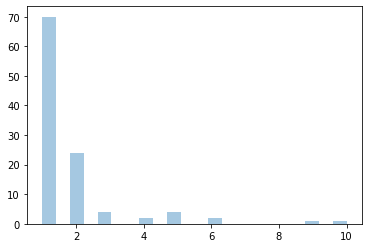

In [71]:
sns.distplot(hex_flood.date.values, kde=False);

On the other hand, we can observe the number of alerts per day.

In [72]:
date_flood = flood[['date','interactions']].groupby(['date']).agg(['count','sum']).droplevel(0, axis=1).rename(columns={'count':'alerts', 'sum':'interactions'}).sort_values('alerts', ascending=False)

In [73]:
date_flood.alerts.describe()

count    70.000000
mean      3.128571
std       3.992462
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max      20.000000
Name: alerts, dtype: float64

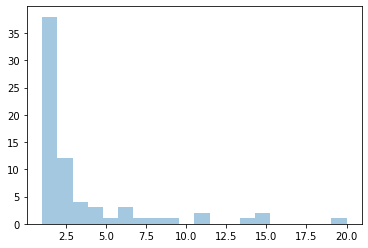

In [74]:
sns.distplot(date_flood.alerts.values, kde=False);

### Back to data wrangling <a class='tocSkip'>

In [75]:
rain = rain.rename_axis(index={'time':'date'})

In [76]:
data = rain.join(fday8,  how='right').reset_index(level=1)

In [77]:
all_days_set = set(rain.index.to_series().apply(lambda x: dt.date(x.to_pydatetime())).to_list())

In [78]:
hex8_date_sets['not_date'] = all_days_set - hex8_date_sets['date']

In [79]:
def negative_sampling(row, ns=5):
    sample_size = len(row['date']) * ns
    sample_size = sample_size if sample_size <= len(row['not_date']) else len(row['not_date'])
    return random.sample(row['not_date'], sample_size)

In [80]:
hex8_date_sets['negative_samples'] = hex8_date_sets.apply(negative_sampling, 1)

In [81]:
negative_samples = hex8_date_sets['negative_samples'].apply(pd.Series).stack().reset_index(level=-1, drop=True)

In [82]:
negative_samples = negative_samples.apply(pd.to_datetime).to_frame(name='date').merge(rain, left_on='date', right_index=True, how='left')

In [83]:
negative_samples['hex8_prevDayFlooded'] = negative_samples.reset_index().apply(lambda row: (row['date'] - pd.Timedelta('1D')) in hex8_date_sets.loc[row['hex8'], 'date'], 1).values
negative_samples['interactions'] = 0
negative_samples['alerts'] = 0

In [84]:
data = pd.concat([data, negative_samples])

In [85]:
data = data.dropna()

In [86]:
data['target'] = (data['alerts'] > 0).apply(int)

# Hexagon Models

## Logistic Regression

In [87]:
data1 = data.drop(columns=['date','interactions','alerts','precipAccum','precipAccum_D-1','precipAccum_D-2', 'precipIntensity'])

In [88]:
data1.head()

,Saturday,Sunday,cloudCover,hex8_prevDayFlooded,humidity,precipAccum_D-1_quantized,precipAccum_D-2_quantized,precipAccum_quantized,windSpeed,target
hex8,,,,,,,,,,
88c2f10b61fffff,0,1,0.64,False,0.81,2.0,4.0,2,1.21,1
88c2f10b63fffff,1,0,0.29,False,0.64,2.0,2.0,0,4.15,1
88c2f10b6dfffff,0,1,0.90,False,0.83,3.0,3.0,4,4.28,1
88c2f11905fffff,0,0,0.33,False,0.73,4.0,3.0,2,4.04,1
88c2f11905fffff,0,0,0.90,False,0.89,4.0,3.0,4,2.86,1


In [89]:
def X_data(data):
    return data.iloc[:,:-1].values

def Y_data(data):
    return data.loc[:,'target'].values

In [90]:
hex_model = data1.groupby(level=0).apply(X_data).to_frame(name='X').join(data1.groupby(level=0).apply(Y_data).to_frame(name='Y'))

In [91]:
hex_model['logistic_fitted'] = hex_model.apply(lambda row: LogisticRegression().fit(row['X'],row['Y']), 1)

In [92]:
hex_logistic_predictors = hex_model['logistic_fitted'].apply(lambda model: pd.Series(model.coef_[0], index=data1.columns[:-1]))

In [93]:
hex_logistic_predictors.head()

,Saturday,Sunday,cloudCover,hex8_prevDayFlooded,humidity,precipAccum_D-1_quantized,precipAccum_D-2_quantized,precipAccum_quantized,windSpeed
hex8,,,,,,,,,
88c2f10b61fffff,0.000000,0.237235,0.059593,0.00000,0.018350,0.218012,0.234343,0.272286,-0.829250
88c2f10b63fffff,0.407461,0.000000,-0.127056,0.00000,0.027605,0.266620,-0.130106,-0.847006,-0.086705
88c2f10b6dfffff,-0.116191,0.463825,0.129923,0.00000,-0.067595,-0.152505,0.215309,0.637375,-0.684699
88c2f11905fffff,-0.303134,-0.026499,0.150214,-0.02604,-0.072413,0.503015,0.140987,0.197564,-0.873952
88c2f11921fffff,-0.553626,-0.051014,0.016335,0.00000,-0.230050,-0.024486,-0.736736,0.507288,0.011426


# Modelling on Day level

## Preparing Dataset

In [94]:
rain.head(2)

,cloudCover,humidity,precipIntensity,windSpeed,precipAccum,precipAccum_D-1,precipAccum_D-2,precipAccum_quantized,precipAccum_D-1_quantized,precipAccum_D-2_quantized,Saturday,Sunday
date,,,,,,,,,,,,
2018-10-01,0.52,0.65,0.2475,6.79,5.9400,NaN,NaN,4,NaN,NaN,0,0
2018-10-02,0.15,0.49,0.0011,2.29,0.0264,5.94,NaN,1,4.0,NaN,0,0


In [95]:
flood.head(2)

,uuid,latitude,longitude,interactions,street,reliability,start_time,end_time,share,cum_share,geometry,hex8,hex9,date,hex8_prevDayFlooded
0,b336ef4a-a85c-3cac-b448-75e50cc23d7c,-34.878758,-56.071303,36,Av. Italia,10,2019-01-07 01:56:00.000,2019-01-07 04:16:00.000,0.0849,0.084906,POINT (-56.071303 -34.878758),88c2f150dbfffff,89c2f150db3ffff,2019-01-07,False
1,2606c07f-96a3-3fef-817d-e5b087574ef8,-34.863587,-56.169005,10,NaN,10,2019-01-02 14:05:00.000,2019-01-02 15:42:00.000,0.0236,0.108491,POINT (-56.16900500000001 -34.863587),88c2f15603fffff,89c2f15602fffff,2019-01-02,False


In [96]:
day_grouped = flood[['interactions','hex8_prevDayFlooded', 'date']].groupby('date')

In [97]:
data_day = day_grouped.agg({'interactions':['count','sum']}).droplevel(0, axis=1).rename(columns={'count':'alerts', 'sum':'interactions'})

In [98]:
days_flooded_set = set(data_day.index.to_series().apply(lambda x: dt.date(x.to_pydatetime())).to_list())

In [99]:
rain['dayFlooded'] = pd.Series(rain.index.map(lambda i: dt.date(i.to_pydatetime()) in days_flooded_set)).values
rain['prevDayFlooded'] = rain.shift(1).dayFlooded

In [100]:
data_day = rain.join(data_day, how='outer')

In [101]:
data_day[['alerts', 'interactions']] = data_day[['alerts','interactions']].fillna(value=0)

In [102]:
data_day['target'] = (data_day['alerts'] > 0).apply(int)

Creating a copy o data_day in order to train and test a prediction model of flood occurrences

In [103]:
data_day1 = data_day.drop(columns=['interactions','alerts','dayFlooded','precipAccum','precipAccum_D-1','precipAccum_D-2', 'precipIntensity'])

In [104]:
data_day1.head()

,cloudCover,humidity,windSpeed,precipAccum_quantized,precipAccum_D-1_quantized,precipAccum_D-2_quantized,Saturday,Sunday,prevDayFlooded,target
date,,,,,,,,,,
2018-10-01,0.52,0.65,6.79,4,NaN,NaN,0,0,NaN,0
2018-10-02,0.15,0.49,2.29,1,4.0,NaN,0,0,False,0
2018-10-03,0.17,0.58,3.62,1,1.0,4.0,0,0,False,0
2018-10-04,0.09,0.58,3.89,0,1.0,1.0,0,0,False,0
2018-10-05,0.41,0.63,3.81,1,0.0,1.0,0,0,False,0


In [105]:
data_day1 = data_day1.dropna()

In [106]:
data_day1.shape

(328, 10)

In [107]:
print(data_day1[data_day1['target']==1].shape[0])
print(data_day1[data_day1['target']==0].shape[0])

70
258


In [108]:
X_train, X_test, y_train, y_test = train_test_split(data_day1.drop('target',axis=1), data_day1['target'], test_size=0.30, 
                                                    random_state=42)

## Logistic Regression

### Stats Model

In [109]:
X_train = X_train.astype({'prevDayFlooded': 'uint8'})

In [110]:
logit_model_sm=sm.Logit(y_train, X_train)
result=logit_model_sm.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.472935
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  229
Model:                          Logit   Df Residuals:                      220
Method:                           MLE   Df Model:                            8
Date:                Tue, 10 Sep 2019   Pseudo R-squ.:                 0.09883
Time:                        16:24:33   Log-Likelihood:                -108.30
converged:                       True   LL-Null:                       -120.18
Covariance Type:            nonrobust   LLR p-value:                  0.002520
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
cloudCover                    1.9657      0.868      2.265      0.023       0.

### Scikit Learn

Note that by default, sklearn LogisticRegression model does a L2 Regularization

In [111]:
logit_model = LogisticRegression(class_weight='balanced').fit(X_train, y_train)

Classification Report
              precision    recall  f1-score   support

   No Floods       0.88      0.71      0.78        79
     Flooded       0.34      0.60      0.44        20

    accuracy                           0.69        99
   macro avg       0.61      0.65      0.61        99
weighted avg       0.77      0.69      0.71        99

ROC Score: 0.6544303797468355
Accuracy Score: 0.6868686868686869
Average Precision Score: 0.2865223665223665
f1 Score: 0.43636363636363634
Confusion matrix, without normalization
[[56 23]
 [ 8 12]]


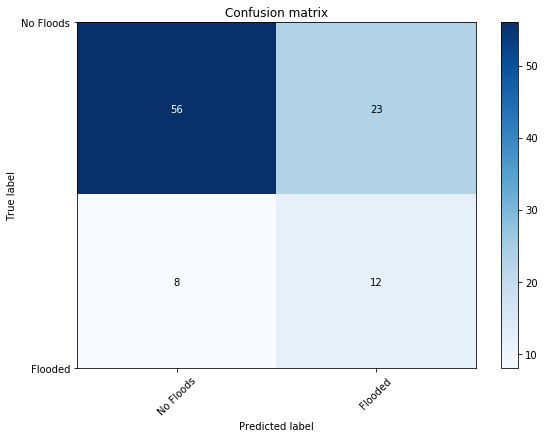

In [112]:
roc = clf_eval(logit_model, X_test, y_test)

Saturday                    -0.316288
windSpeed                   -0.086738
precipAccum_D-1_quantized    0.061116
precipAccum_D-2_quantized    0.136104
precipAccum_quantized        0.366782
Sunday                       0.377433
humidity                     0.377879
prevDayFlooded               0.718479
cloudCover                   1.161226
dtype: float64


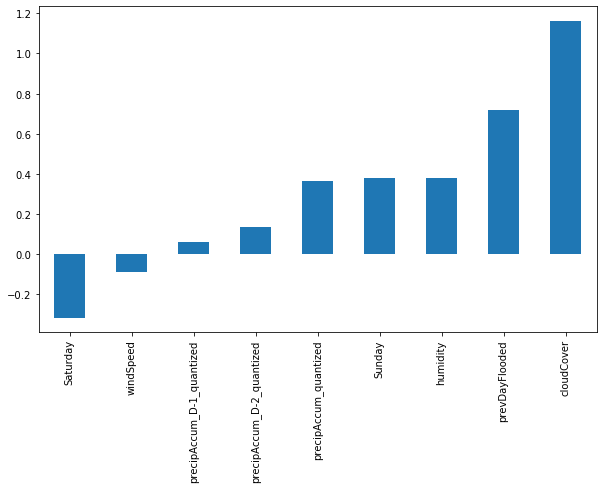

In [113]:
coefs = pd.Series(logit_model.coef_[0], index=X_train.columns)
coefs = coefs.sort_values()
coefs.plot(kind="bar", figsize=(10,6))
print(coefs.sort_values(ascending = True))

# Naive Spatial Model

## Preparing Dataset

In [114]:
data = flood[['interactions','latitude', 'longitude', 'date']]

In [115]:
data = rain.reset_index().merge(data, how='outer', on='date')

In [116]:
data[['interactions']] = data[['interactions']].fillna(value=0)
data[['latitude']] = data[['latitude']].fillna(value=pol.loc[0,'geometry'].centroid.y)
data[['longitude']] = data[['longitude']].fillna(value=pol.loc[0,'geometry'].centroid.x)

In [117]:
data['target'] = (data['interactions'] > 0).apply(int)

Creating a copy o data_day in order to train and test a prediction model of flood occurrences

In [118]:
data = data.drop(columns=['date', 'interactions','dayFlooded','precipAccum','precipAccum_D-1','precipAccum_D-2', 'precipIntensity'])

In [119]:
data.head()

,cloudCover,humidity,windSpeed,precipAccum_quantized,precipAccum_D-1_quantized,precipAccum_D-2_quantized,Saturday,Sunday,prevDayFlooded,latitude,longitude,target
0,0.52,0.65,6.79,4,NaN,NaN,0,0,NaN,-34.818127,-56.213858,0
1,0.15,0.49,2.29,1,4.0,NaN,0,0,False,-34.818127,-56.213858,0
2,0.17,0.58,3.62,1,1.0,4.0,0,0,False,-34.818127,-56.213858,0
3,0.09,0.58,3.89,0,1.0,1.0,0,0,False,-34.818127,-56.213858,0
4,0.41,0.63,3.81,1,0.0,1.0,0,0,False,-34.818127,-56.213858,0


In [120]:
data = data.dropna()

In [121]:
data.shape

(477, 12)

In [122]:
print(data[data['target']==1].shape[0])
print(data[data['target']==0].shape[0])

219
258


In [123]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target',axis=1), data['target'], test_size=0.30, 
                                                    random_state=42)

## Logistic Regression

### Stats Model

In [124]:
X_train.dtypes

cloudCover                   float64
humidity                     float64
windSpeed                    float64
precipAccum_quantized          int64
precipAccum_D-1_quantized    float64
precipAccum_D-2_quantized    float64
Saturday                       uint8
Sunday                         uint8
prevDayFlooded                object
latitude                     float64
longitude                    float64
dtype: object

In [125]:
X_train = X_train.astype({'prevDayFlooded': 'uint8'})

In [126]:
logit_model_sm=sm.Logit(y_train, X_train)
result=logit_model_sm.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.153413
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  333
Model:                          Logit   Df Residuals:                      322
Method:                           MLE   Df Model:                           10
Date:                Tue, 10 Sep 2019   Pseudo R-squ.:                  0.7780
Time:                        16:24:36   Log-Likelihood:                -51.087
converged:                       True   LL-Null:                       -230.16
Covariance Type:            nonrobust   LLR p-value:                 7.465e-71
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
cloudCover                    0.2897      1.329      0.218      0.827      -2.

### Scikit Learn

Note that by default, sklearn LogisticRegression model does a L2 Regularization

In [127]:
logit_model = LogisticRegression().fit(X_train, y_train)

Classification Report
              precision    recall  f1-score   support

   No Floods       0.88      0.81      0.85        81
     Flooded       0.78      0.86      0.82        63

    accuracy                           0.83       144
   macro avg       0.83      0.84      0.83       144
weighted avg       0.84      0.83      0.83       144

ROC Score: 0.835978835978836
Accuracy Score: 0.8333333333333334
Average Precision Score: 0.7333074534161491
f1 Score: 0.8181818181818182
Confusion matrix, without normalization
[[66 15]
 [ 9 54]]


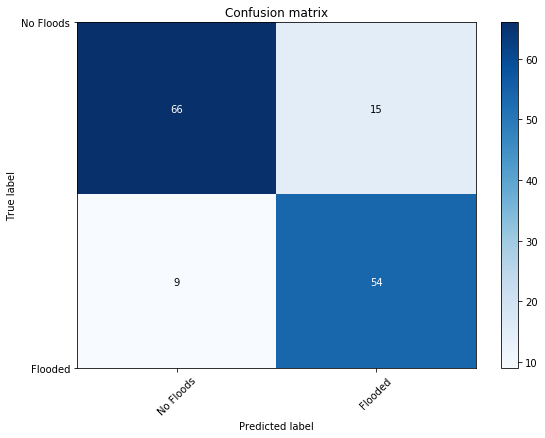

In [128]:
roc = clf_eval(logit_model, X_test, y_test)

latitude                    -2.766109
precipAccum_D-2_quantized   -0.006011
windSpeed                    0.076260
precipAccum_D-1_quantized    0.130548
Sunday                       0.140140
Saturday                     0.319930
precipAccum_quantized        0.613675
prevDayFlooded               0.923805
cloudCover                   1.290643
longitude                    1.808055
humidity                     1.927056
dtype: float64


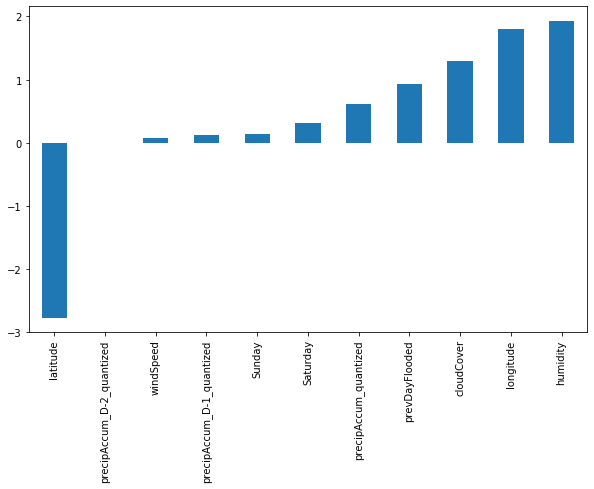

In [129]:
coefs = pd.Series(logit_model.coef_[0], index=X_train.columns)
coefs = coefs.sort_values()
coefs.plot(kind="bar", figsize=(10,6))
print(coefs.sort_values(ascending = True))

# Kernel Density Estimation on Linear Network

## Matching Alerts to Streets in Graph

In [130]:
# We use projected graph for better accuracy in KDTree method
edges_with_potholes = phc.match_roads_to_points(city, flood, G_proj)

In [131]:
nx.set_edge_attributes(G_proj, 0, 'alerts_count')
nx.set_edge_attributes(G_proj, 0, 'interactions')
nx.set_edge_attributes(G_proj, edges_with_potholes)

In [132]:
nx.set_edge_attributes(G, 0, 'alerts_count')
nx.set_edge_attributes(G, 0, 'interactions')
nx.set_edge_attributes(G, edges_with_potholes)

In [133]:
### Feito o match, iremos analisar os segmentos com os buracos
nodes, edges = ox.graph_to_gdfs(G_proj) 

The image below shows all street sections where flood alerts have been reported, in which the intensity of the colors indicates the amount of interactions of app users with such alerts.

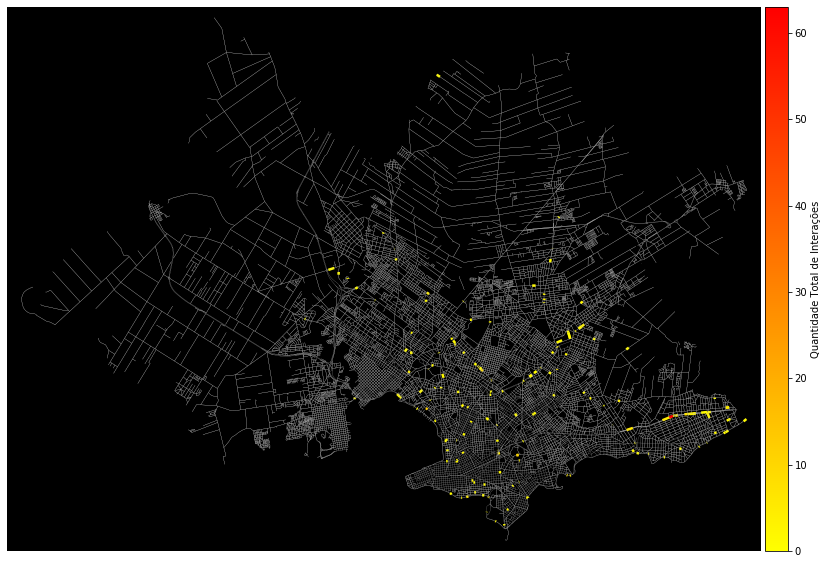

In [134]:
phc.plot_graph_potholes(G_proj, fig_width=None)

## Applying R code

In [135]:
nodes_xy = nodes.reset_index()[['x','y']]

In [136]:
bbox = gpd.GeoSeries(box(pol.loc[0,'bbox_west'],pol.loc[0,'bbox_south'],pol.loc[0,'bbox_east'],pol.loc[0,'bbox_north']),
                crs='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs').to_crs(G_proj.graph['crs'])[0].bounds

(xmin, ymin, xmax, ymax) = bbox

In [137]:
node_index = nodes.reset_index(drop=True).reset_index().set_index('osmid')['index'].to_dict()

edges_list = edges[['u','v']]

edges_list['U'] = edges.u.apply(lambda u: node_index[u])
edges_list['V'] = edges.v.apply(lambda u: node_index[u])

edges_list = edges_list[['U','V']]
edges_list = edges_list + 1 

In [138]:
flood['point_proj_on_edge'] = phc.project_alert_on_nearest_edge(city, flood, G_proj)

flood['X'] = flood['point_proj_on_edge'].apply(lambda point: point.x)
flood['Y'] = flood['point_proj_on_edge'].apply(lambda point: point.y)

alerts_xy = flood[['X','Y']]

In [140]:
%%R
library(spatstat)

In [141]:
%%R -i nodes_xy,xmin,xmax,ymin,ymax,edges_list,alerts_xy

#install.packages('spatstat', repos='http://cran.us.r-project.org', quiet=TRUE)

vertices <- as.ppp(nodes_xy, c(xmin, xmax, ymin, ymax))
edges <- as.matrix(edges_list)
L <- linnet(vertices, edges=edges, sparse=TRUE)

In [ ]:
%%R

pplinnet <- lpp(alerts_xy, L)

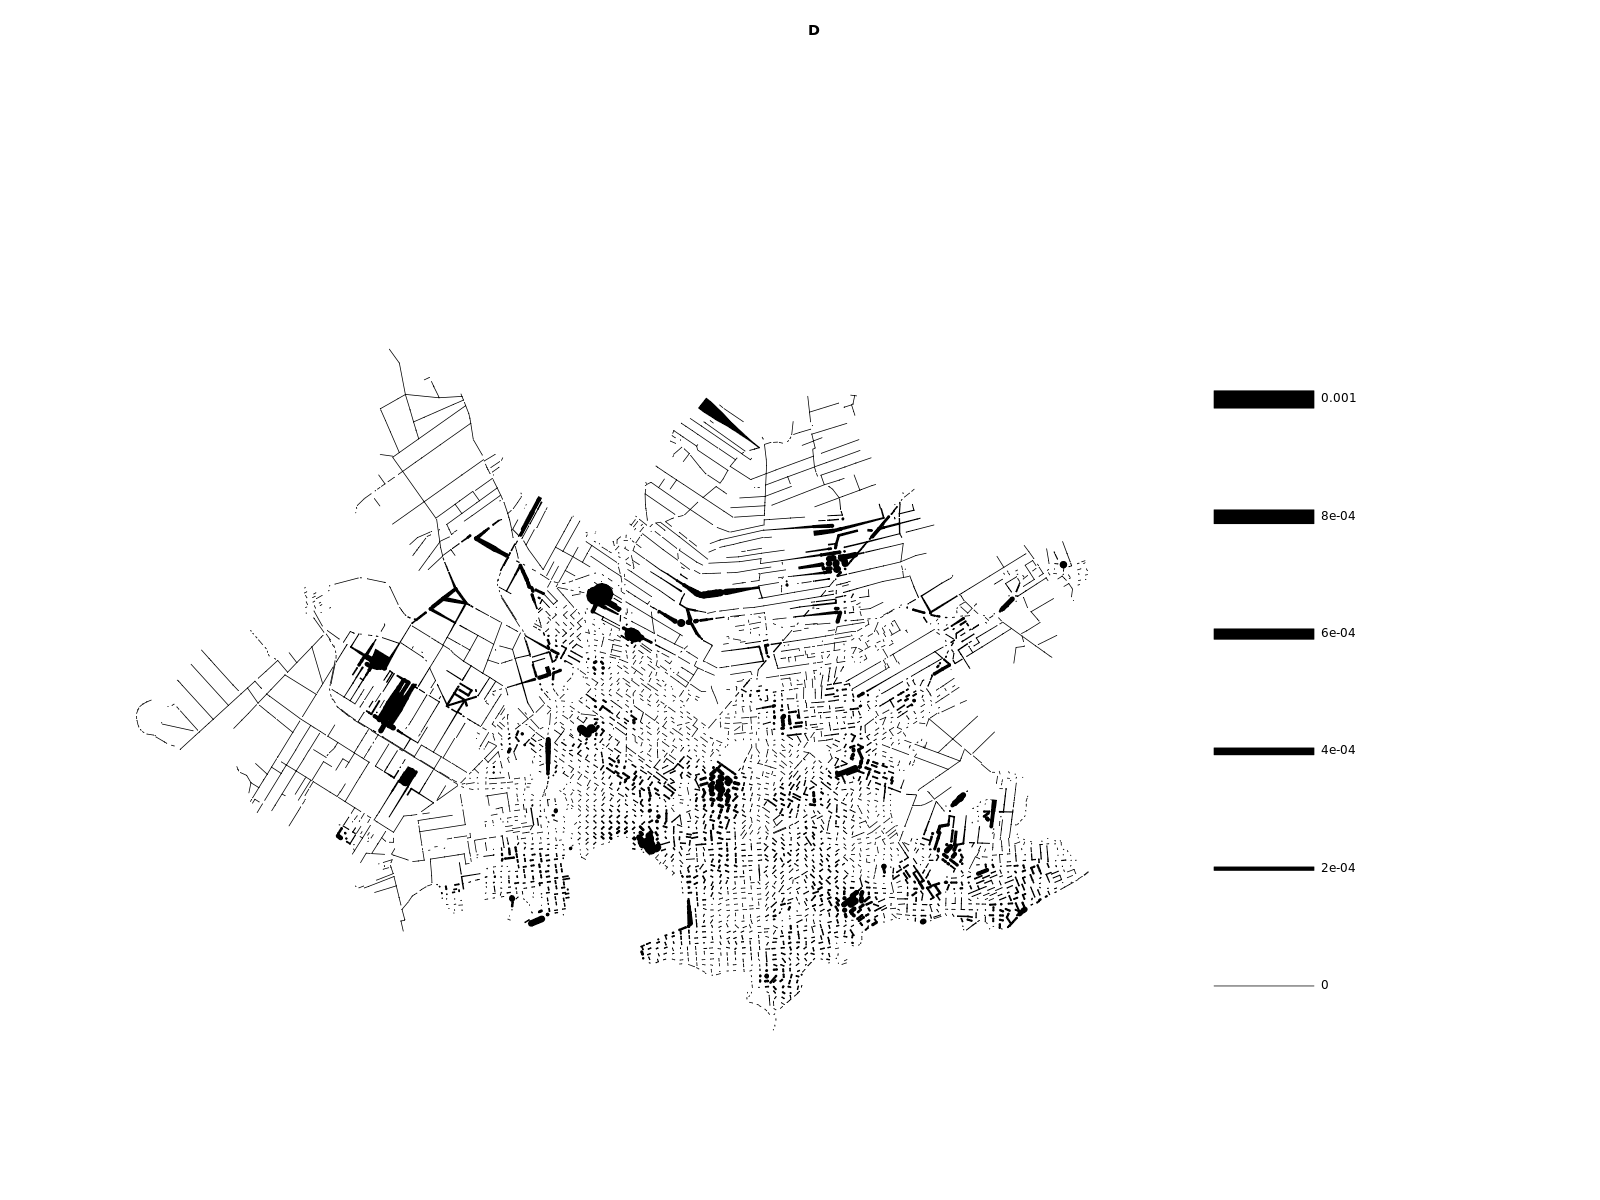

In [148]:
%%R -h 1200 -w 1600

D <- density(pplinnet, 1000, verbose=FALSE)

plot(D, style="w")

In [144]:
%%R

Dquick <- density(pplinnet, distance="euclidean", at="points")
#sessionInfo()

In [145]:
%%R
print(attributes(Dquick)$sigma)

[1] 3310.286


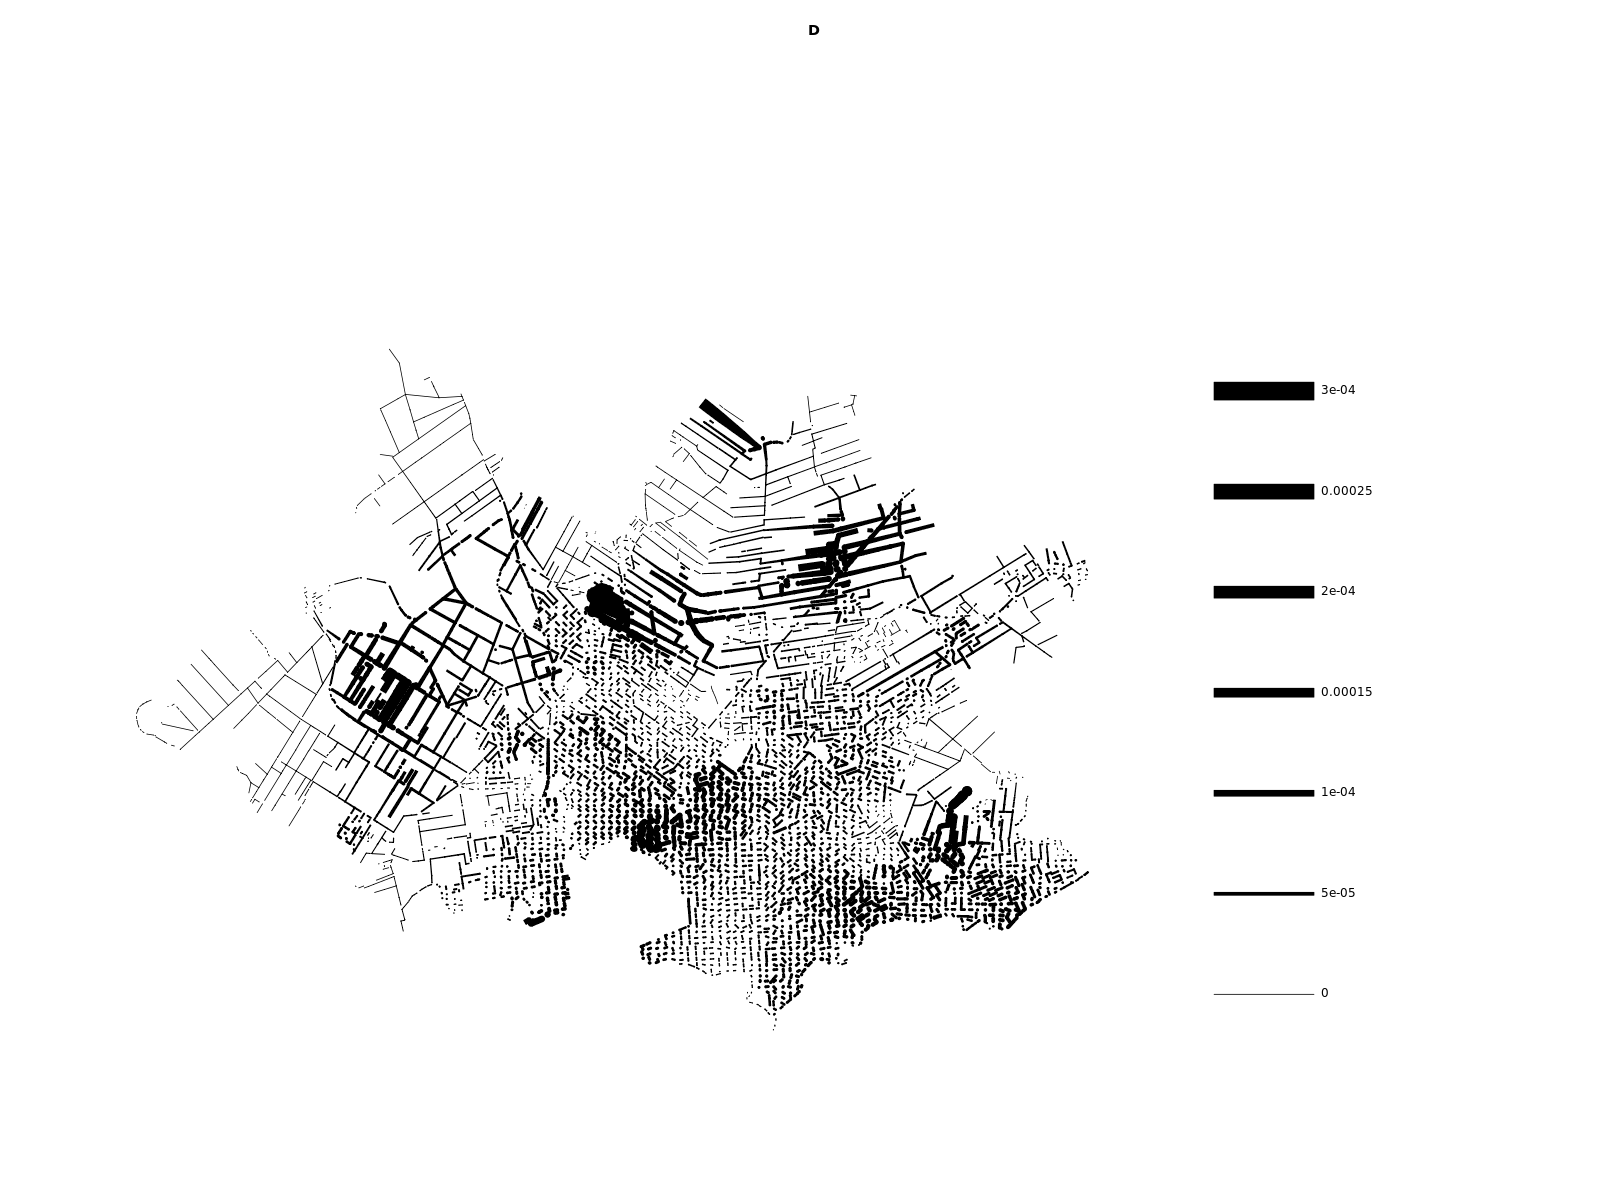

In [153]:
%%R -h 1200 -w 1600

D <- density(pplinnet, attributes(Dquick)$sigma, verbose=FALSE)

plot(D, style="w")